In [28]:
import pandas as pd

In [29]:
from script import df_mobpro_brut, arr_marseille, arr_paris, arr_lyon

In [30]:
df_mobpro_brut.sample()

,Unnamed: 0,COMMUNE,ARM,DCFLT,DCLT,AGEREVQ,CS1,DEROU,DIPL,EMPL,...,REGION,REGLT,SEXE,STAT,STOCD,TP,TRANS,TYPL,TYPMR,VOIT
3075389,3075389,49007,ZZZZZ,99999,49007,40,4,Z,17,16,...,52,52,2,10,10,1,2,1,41,1


Ce que signifient chacune des en-têtes de colonnes :  
COMMUNE Département et commune du lieu de résidence  
ARM Arrondissement municipal de résidence (Paris, Lyon et Marseille)  
DCFLT Commune frontalière du lieu de travail  
DCLT Département, commune et arrondissement municipal (Paris, Lyon, Marseille) du lieu de travail  
AGEREVQ Âge quinquennal en années révolues  
CS1 Catégorie socioprofessionnelle en 8 postes  
DEROU Nombre de deux-roues à moteur du ménage (DOM)  
DIPL_15 Diplôme le plus élevé  
EMPL Condition d'emploi  
ILTUU Indicateur urbain du lieu de travail  
ILT Indicateur du lieu de travail  
IMMI Situation quant à l'immigration  
INATC Indicateur de nationalité condensé (Français/Étranger)  
INEEM Nombre d'élèves, étudiants ou stagiaires âgés de 14 ans ou plus du ménage  
INPOM Nombre de personnes actives ayant un emploi du ménage  
INPSM Nombre de personnes scolarisées du ménage  
IPONDI Poids de l'individu  
LPRM Lien à la personne de référence du ménage  
METRODOM Indicateur Métropole ou DOM du lieu de résidence  
MOCO Mode de cohabitation  
NA5 Activité économique regroupée en 5 postes  
NPERR Nombre de personnes du ménage (regroupé)  
REGION Région du lieu de résidence  
REGLT Région du lieu de travail  
SEXE Sexe  
STAT Statut professionnel  
STOCD Statut d'occupation détaillé du logement  
TP Temps de travail  
TRANS Mode de transport principal le plus souvent utilisé pour aller travailler  
TYPL Type de logement  
TYPMR Type de ménage regroupé (en 9 postes)  
VOIT Nombre de voitures du ménage  

La fonction ci-dessous permet d'obtenir un premier tableau regroupant ceratines informations par commune :
- Nombre de personnes du ménage (regroupé)
- Nombre de personnes scolarisées du ménage
- Nombre de personnes actives ayant un emploi du ménage
- Nombre d'élèves, étudiants ou stagiaires âgés de 14 ans ou plus du ménage
- Indicateur du lieu de travail
(1 Dans la commune de résidence actuelle
2 Dans une autre commune du département de résidence
3 Dans un autre département de la région de résidence
4 Hors de la région de résidence actuelle : en métropole
5 Hors de la région de résidence actuelle : dans un DOM
6 Hors de la région de résidence actuelle : dans une COM
7 A l'étranger)

In [4]:
# Conversion des colonnes en numérique
df_mobpro_brut['NPERR'] = pd.to_numeric(df_mobpro_brut['NPERR'], errors='coerce')
df_mobpro_brut['INPSM'] = pd.to_numeric(df_mobpro_brut['INPSM'], errors='coerce')
df_mobpro_brut['INPOM'] = pd.to_numeric(df_mobpro_brut['INPOM'], errors='coerce')
df_mobpro_brut['INEEM'] = pd.to_numeric(df_mobpro_brut['INEEM'], errors='coerce')

# Création des agrégations de base
mobpro_villes = df_mobpro_brut.groupby('COMMUNE').agg({
    'NPERR': 'sum',
    'INPSM': 'sum',
    'INPOM': 'sum',
    'INEEM': 'sum'})

# Créons d'abord un DataFrame temporaire pour chaque valeur d'ILT
for i in range(1, 8):
    # Grouper par COMMUNE et compter les occurrences où ILT == str(i)
    temp_count = df_mobpro_brut[df_mobpro_brut['ILT'] == i].groupby('COMMUNE').size()
    # Ajouter cette série au DataFrame principal
    mobpro_villes[f'ILT_{i}'] = temp_count

# Remplir les valeurs manquantes (NaN) par 0
mobpro_villes = mobpro_villes.fillna(0)

# Réinitialisation de l'index
mobpro_villes = mobpro_villes.reset_index()


In [ ]:
mobpro_villes

# Matrice des flux

On souhaite créer une matrice des flux pour avoir une vision générale des trajets domicile-travail quotidiens entre les villes. Pour chaque couple de ville, le nombre correspondant dans la matrice correspond au nombre de commute effectué de la ville 1 à la ville 2.

On remarque que pour la variable "COMMUNE" (commune de résidence) on a uniquement 75056 pour Paris (idem pour Lyon et Marseille), tandis que pour la variable "DCLT" (commune de travail) on a un découpage en arrondissement avec les codes 75101,... pour Paris (idem pour Lyon et Marseille). Afin de pallier cette différence, on se cale sur l'échelle des arrondissements en remplaçant la valeur de "COMMUNE" par celle de "ARM" lorsque la ville en question est Paris, Marseille ou Lyon.

On établit maintenant la matrice des flux.

In [ ]:
# Création d'une table croisée dynamique pour compter les déplacements
flux_tot = pd.crosstab(df_mobpro_brut['COMMUNE'], df_mobpro_brut['DCLT'])

# Conversion en DataFrame pour plus de clarté
flux_tot = pd.DataFrame(flux_tot)

# En option, si on veut réinitialiser l'index pour avoir COMMUNE en colonne :
# flux_tot = flux_tot.reset_index()

# Pour voir les dimensions de la matrice
print("Dimensions de la matrice :", flux_tot.shape)


# Filtrer les données pour chaque groupe de transport
df_trans_45 = df_mobpro_brut[df_mobpro_brut['TRANS'].isin([4, 5])]
df_trans_6 = df_mobpro_brut[df_mobpro_brut['TRANS'] == 6]
df_trans_123 = df_mobpro_brut[df_mobpro_brut['TRANS'].isin([1, 2, 3])]

# Créer les matrices des flux pour chaque groupe
flux_rouge = pd.crosstab(df_trans_45['COMMUNE'], df_trans_45['DCLT'])
flux_jaune = pd.crosstab(df_trans_6['COMMUNE'], df_trans_6['DCLT'])
flux_vert = pd.crosstab(df_trans_123['COMMUNE'], df_trans_123['DCLT'])

# Convertir en DataFrame pour plus de clarté
flux_rouge = pd.DataFrame(flux_rouge)
flux_jaune = pd.DataFrame(flux_jaune)
flux_vert = pd.DataFrame(flux_vert)

# Afficher les dimensions des matrices
print("Dimensions de la matrice (TRANS = 4 ou 5) :", flux_rouge.shape)
print("Dimensions de la matrice (TRANS = 6) :", flux_jaune.shape)
print("Dimensions de la matrice (TRANS = 1, 2 ou 3) :", flux_vert.shape)


In [ ]:
flux_tot

In [8]:
def flux(ville_a,ville_b):
    flux = flux_tot.loc[ville_a, ville_b]
    print(f"Nombre de personnes se déplaçant de {ville_a} vers {ville_b} : {flux}")

## Prend en arg deux codes insee en chaîne de caractère et renvoie le nombre de commute entre ces deux villes

In [ ]:
flux('78220', '75108')

In [ ]:
# Top 10 des villes générant le plus de déplacements
top_villes_depart = flux_tot.sum(axis=1).sort_values(ascending=False).head(10)
top_villes_arrivee = flux_tot.sum(axis=0).sort_values(ascending=False).head(10)

print("Top 10 villes de départ :\n", top_villes_depart)
print("Top 10 villes d'arrivée :\n", top_villes_arrivee)

In [33]:
import s3fs
import json
import pandas as pd
import geopandas as gpd

# Information d'accès au cloud MinIO (Bucket de William)
fs = s3fs.S3FileSystem(client_kwargs={"endpoint_url": "https://minio.lab.sspcloud.fr"})
MY_BUCKET = "williamolivier"

# Récupération des tableaux
FILE_PATH_S3_DCB = f"{MY_BUCKET}/diffusion/a-com2022-topo-2154.json"
with fs.open(FILE_PATH_S3_DCB, "rb") as file:
    contours_comm = gpd.read_file(file)


/opt/conda/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'pyogrio_7cee8b6742c4404997a3cd710d00f0ef': 'a_com2022' (default), 'a_reg2022', 'a_dep2022'. Specify layer parameter to avoid this warning.
  result = read_func(


In [34]:
# Calcul des centroïdes
contours_comm["centroid"] = contours_comm.geometry.centroid
# Vérification
print(contours_comm[["codgeo", "centroid"]].head())


  codgeo                        centroid
0  01001  POINT (848608.477 6563339.582)
1  01002  POINT (887854.422 6548406.438)
2  01004  POINT (883688.117 6542884.177)
3  01005  POINT (847979.005 6545822.006)
4  01006  POINT (901674.871 6520029.529)


In [ ]:
# Vérifier le système de projection
print(f"CRS actuel : {contours_comm.crs}")

# Si le CRS est None, on suppose qu'il est en WGS84 (EPSG:4326)
if contours_comm.crs is None:
    print("⚠️ CRS absent ! Attribution par défaut à WGS84 (EPSG:4326).")
    contours_comm.set_crs(epsg=4326, inplace=True)  # On suppose que les coordonnées sont en lat/lon

# Conversion en Lambert 93 (EPSG:2154) si nécessaire
if contours_comm.crs.to_string() != "EPSG:2154":
    contours_comm = contours_comm.to_crs(epsg=2154)
    print("✅ Projection convertie en Lambert 93 (EPSG:2154)")


In [ ]:
pip install scikit-learn


In [ ]:
from sklearn.neighbors import BallTree
import numpy as np

# Extraire les coordonnées des centroïdes sous forme de tableau NumPy
coords = np.array(list(zip(contours_comm["centroid"].x, contours_comm["centroid"].y)))

# Construire l'index spatial
tree = BallTree(coords, metric="euclidean")

# Vérification
print("Index spatial construit avec scikit-learn !")


In [ ]:
# Dictionnaire pour stocker les distances
distance_dict = {}

# Trouver les 10 communes les plus proches pour chaque ville
k = 10  # Nombre de voisins à considérer

for i, codgeo1 in enumerate(contours_comm["codgeo"]):
    # Trouver les k plus proches voisins
    dist, indices = tree.query([coords[i]], k=k+1)  # +1 car la première distance est toujours 0 (soi-même)

    for d, j in zip(dist[0][1:], indices[0][1:]):  # On saute la première (soi-même)
        codgeo2 = contours_comm.iloc[j]["codgeo"]
        
        # Clé unique (peu importe l'ordre)
        key = tuple(sorted((codgeo1, codgeo2)))

        # Stocker la distance (mètres)
        distance_dict[key] = d

print("Distances calculées pour les paires les plus proches !")


In [ ]:
# Afficher quelques distances
print(list(distance_dict.items())[:10])  # 10 premières paires

# Nombre total de distances calculées
print(f"Nombre total de distances stockées : {len(distance_dict)}")

In [35]:
contours_comm

,id,codgeo,dep,reg,xcl2154,ycl2154,libgeo,geometry,centroid
0,None,01001,01,84,848241,6563021,L'Abergement-Clémenciat,"POLYGON ((846981.436 6564107.36, 847017.457 65...",POINT (848608.477 6563339.582)
1,None,01002,01,84,887495,6548152,L'Abergement-de-Varey,"POLYGON ((886027.651 6548170.9, 886157.325 654...",POINT (887854.422 6548406.438)
2,None,01004,01,84,882724,6542583,Ambérieu-en-Bugey,"POLYGON ((884889.404 6539629.931, 884795.75 65...",POINT (883688.117 6542884.177)
3,None,01005,01,84,847277,6545791,Ambérieux-en-Dombes,"POLYGON ((845951.25 6547999.078, 846073.72 654...",POINT (847979.005 6545822.006)
4,None,01006,01,84,902191,6519791,Ambléon,"POLYGON ((901336.361 6521123.305, 902460.201 6...",POINT (901674.871 6520029.529)
...,...,...,...,...,...,...,...,...,...
34950,None,97615,976,06,570763,6101694,Pamandzi,"POLYGON ((570365.656 6102429.686, 570416.084 6...",POINT (571959.872 6101926.563)
34951,None,97616,976,06,549586,6095929,Sada,"POLYGON ((551541.346 6096924.233, 551613.387 6...",POINT (551117.28 6094186.47)
34952,None,97617,976,06,549653,6103182,Tsingoni,"POLYGON ((552341.001 6107748.998, 555071.354 6...",POINT (553350.61 6104139.683)
34953,None,16233,16,75,464776,6506602,Mosnac-Saint-Simeux,"POLYGON ((461871.928 6506962.335, 462088.051 6...",POINT (464358.07 6507525.044)


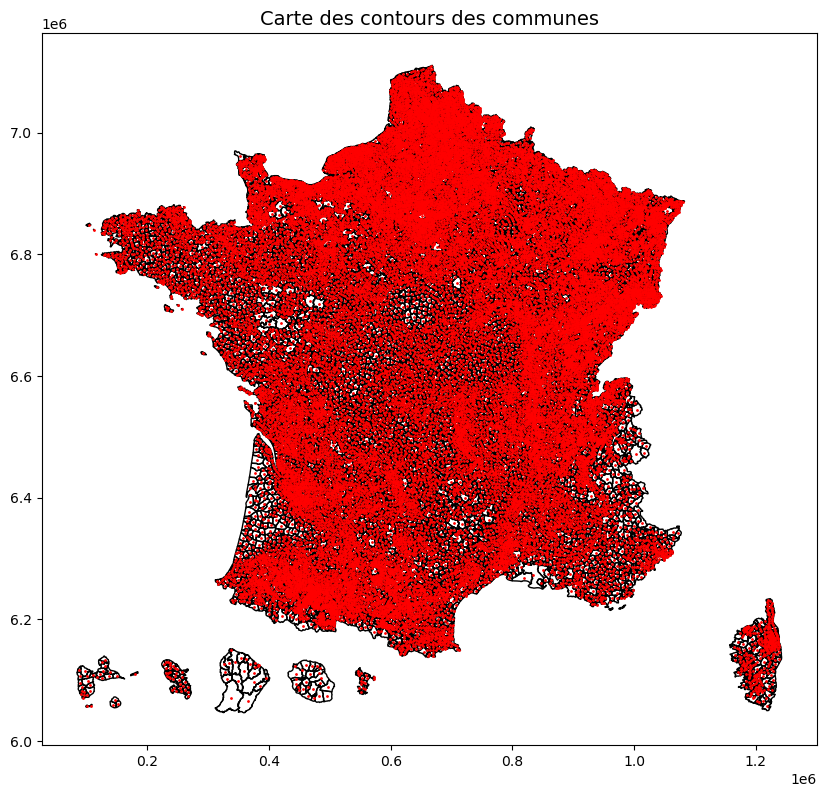

In [36]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Charger le DataFrame contours_comm (Assurez-vous qu'il est bien un GeoDataFrame)
if not isinstance(contours_comm, gpd.GeoDataFrame):
    contours_comm = gpd.GeoDataFrame(contours_comm, geometry="geometry")

# Vérifier et nettoyer les géométries invalides
contours_comm = contours_comm[contours_comm.geometry.notnull()]

# Afficher la carte
fig, ax = plt.subplots(figsize=(10, 10))
contours_comm.plot(ax=ax, edgecolor="black", facecolor="none")  # Contours en noir

# Ajouter les centroïdes pour situer les communes
contours_comm.centroid.plot(ax=ax, color="red", markersize=1)

# Ajouter un titre
plt.title("Carte des contours des communes", fontsize=14)
plt.show()
